[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


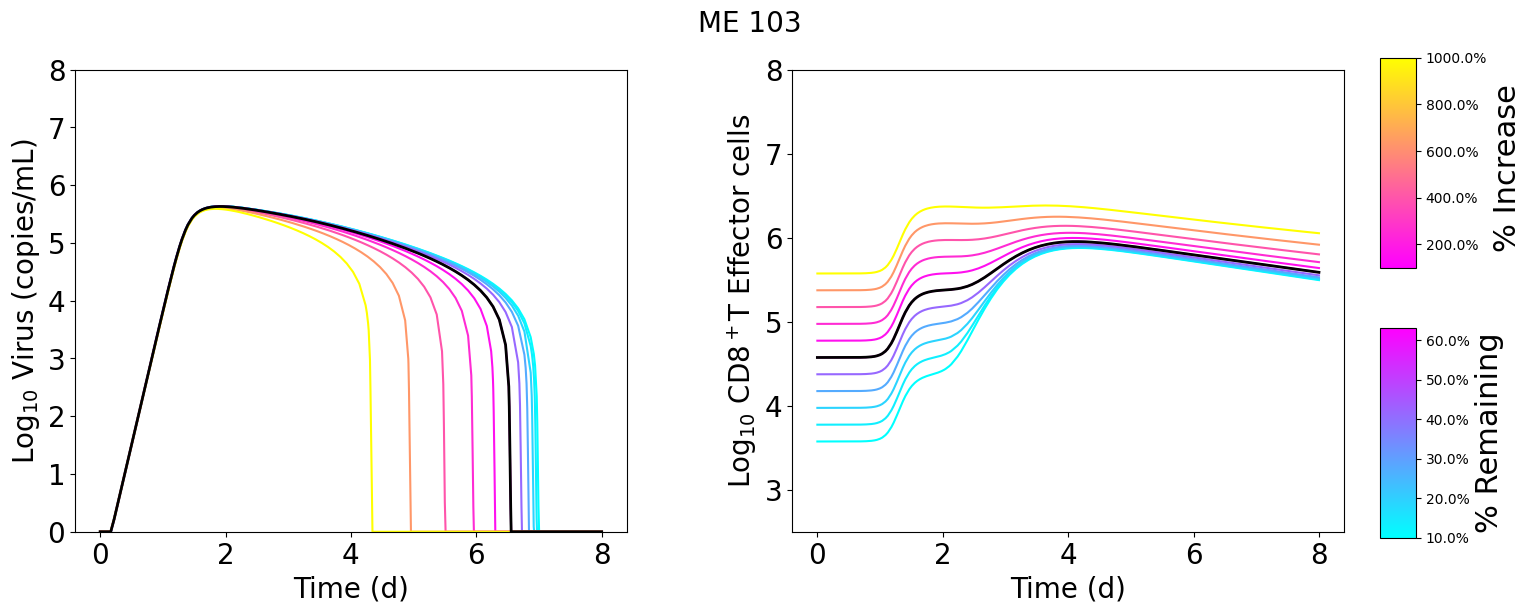

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


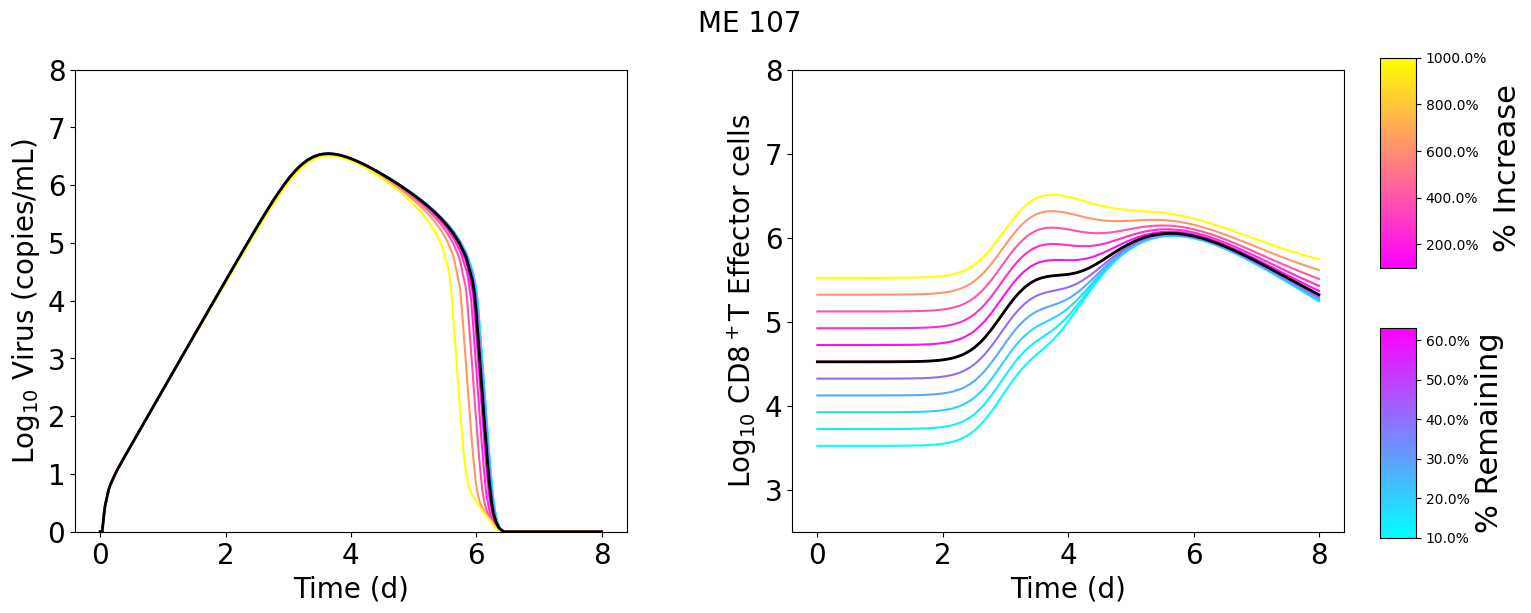

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


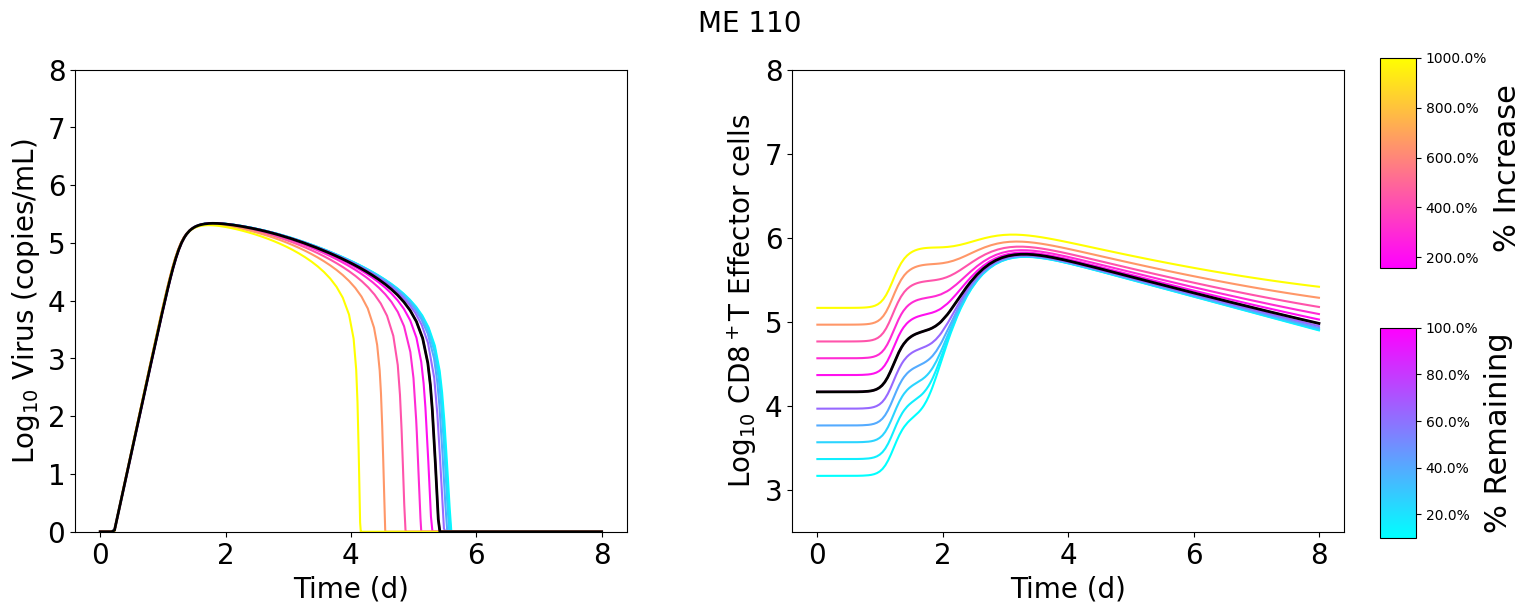

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


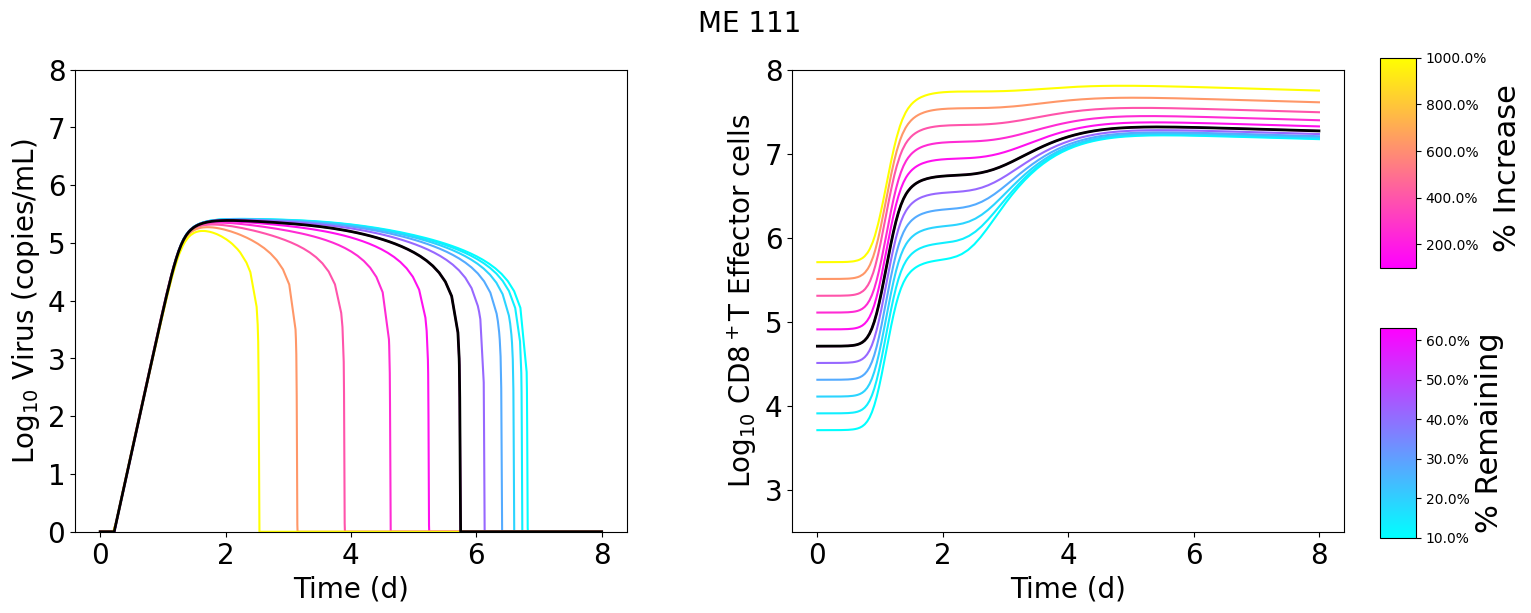

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


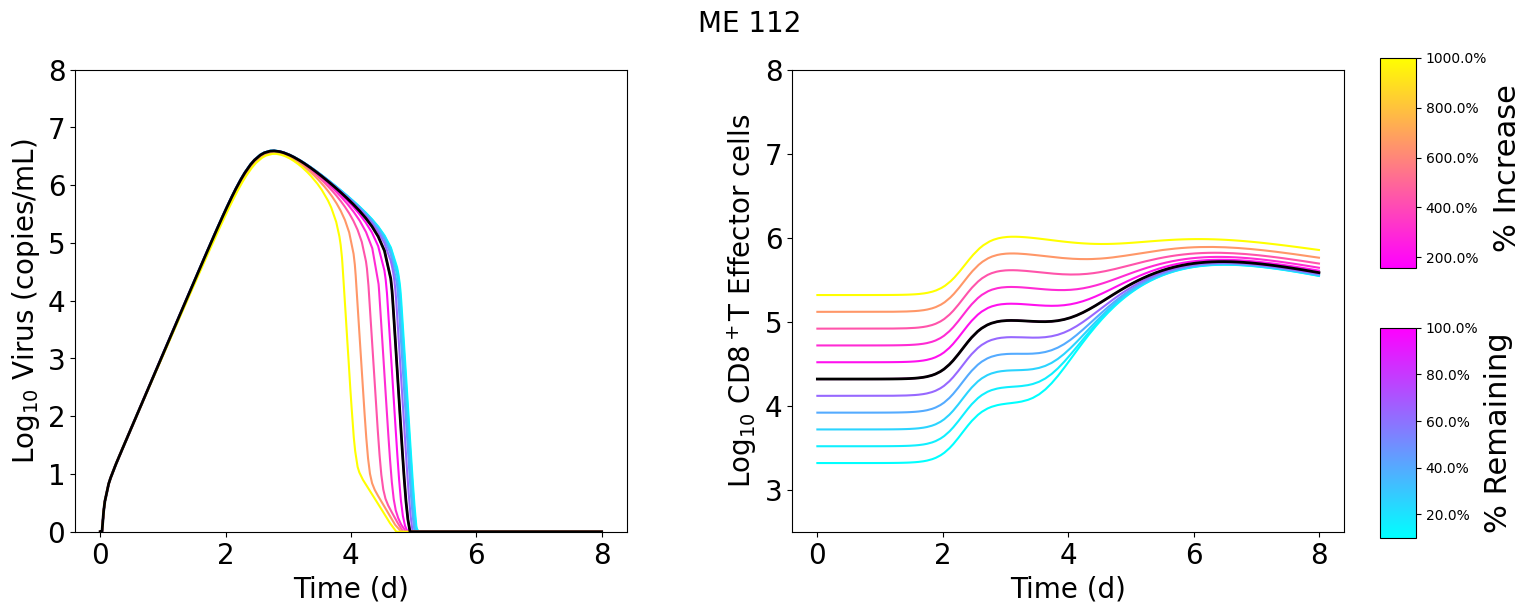

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


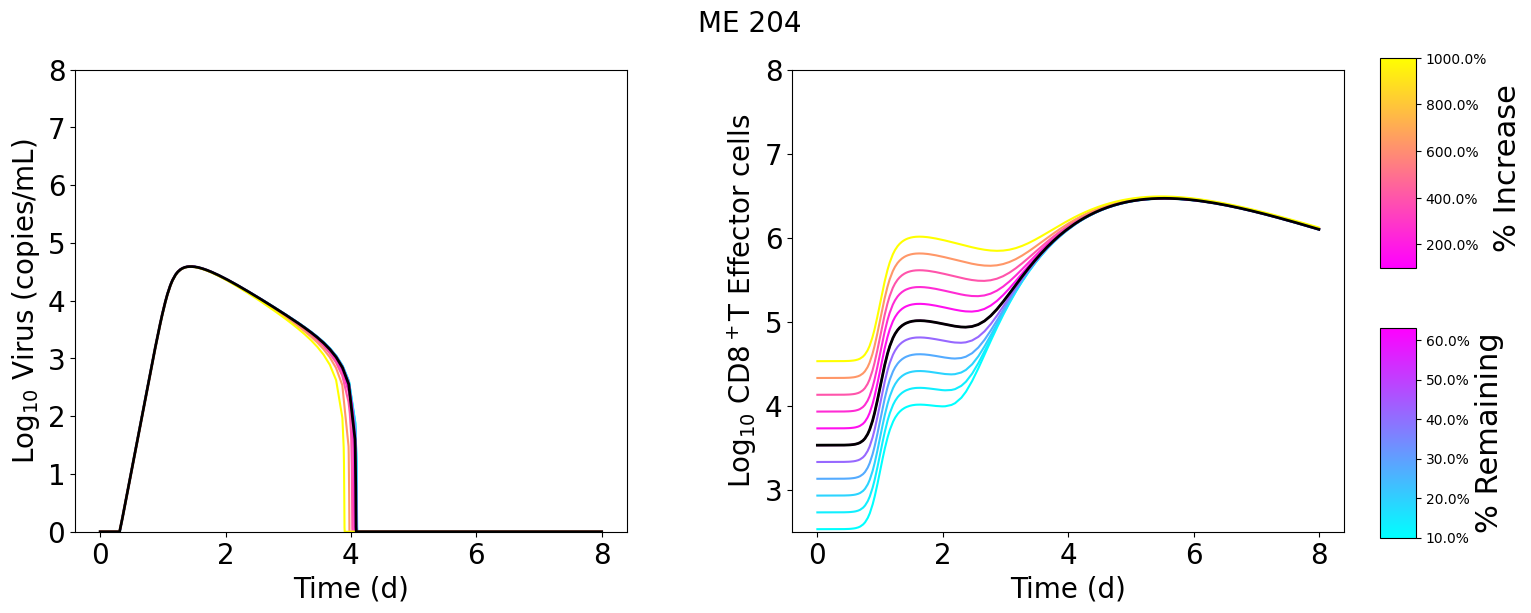

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


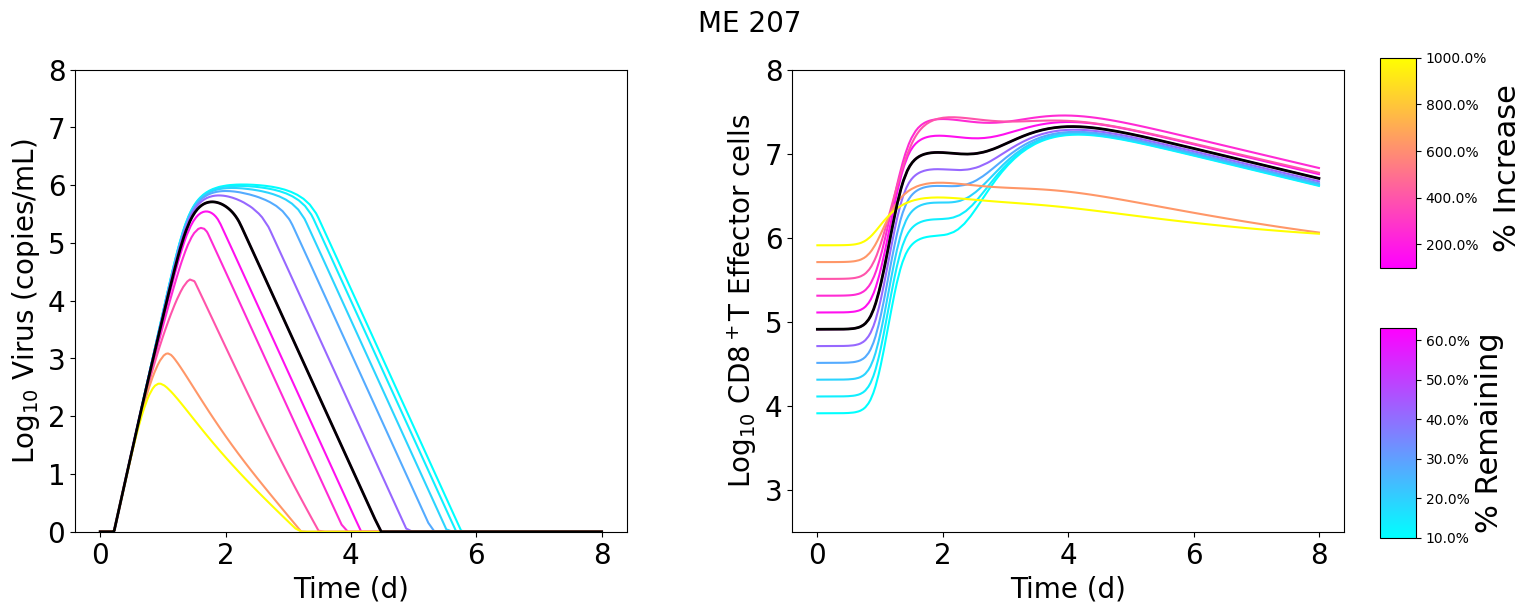

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


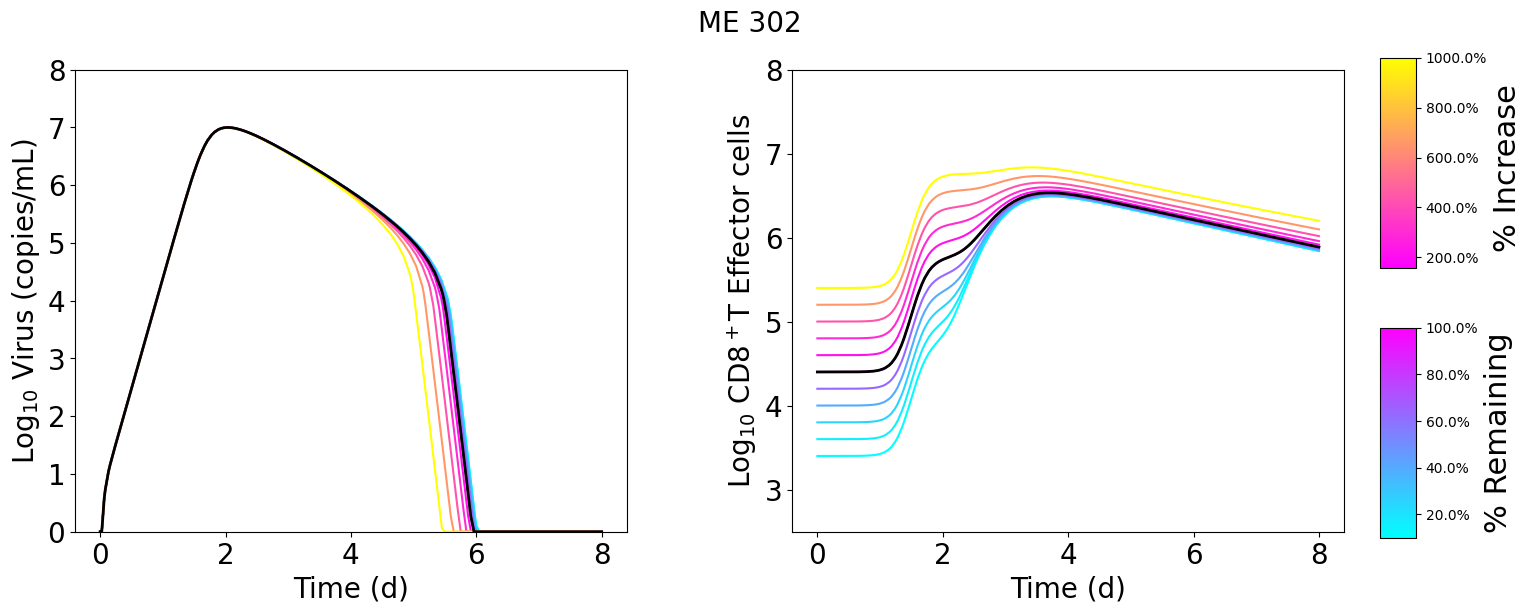

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


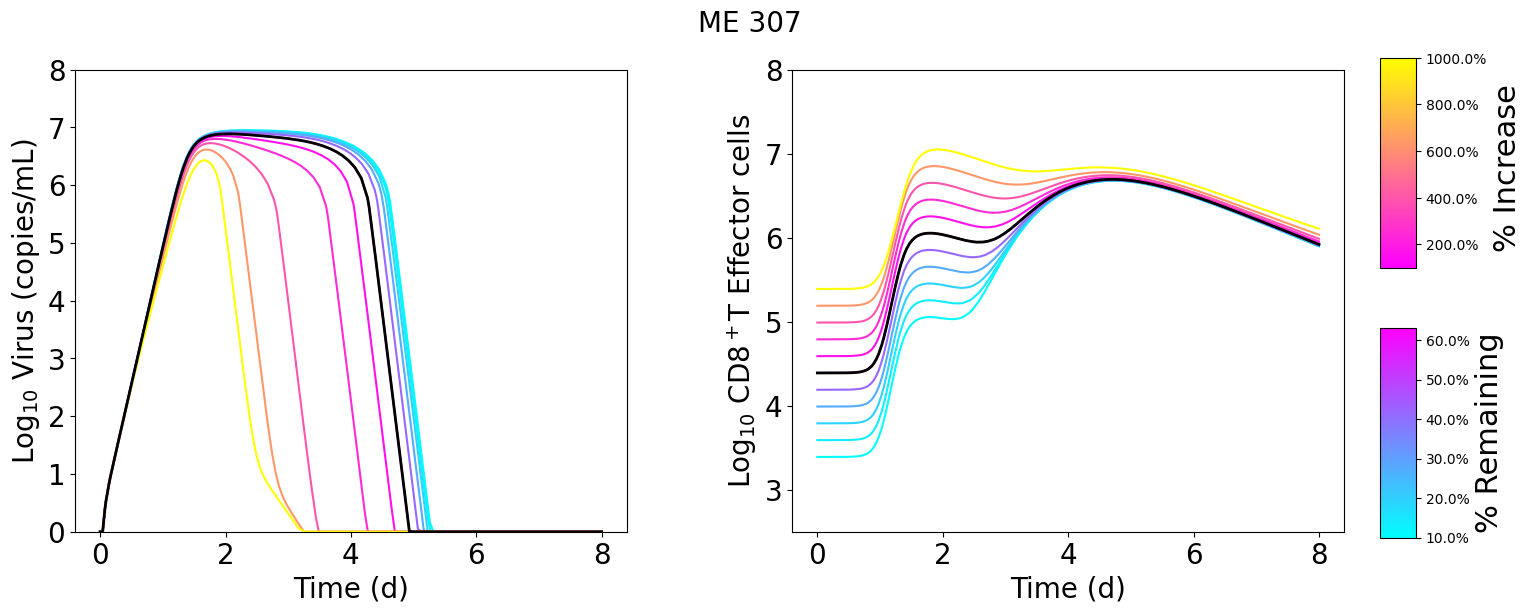

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


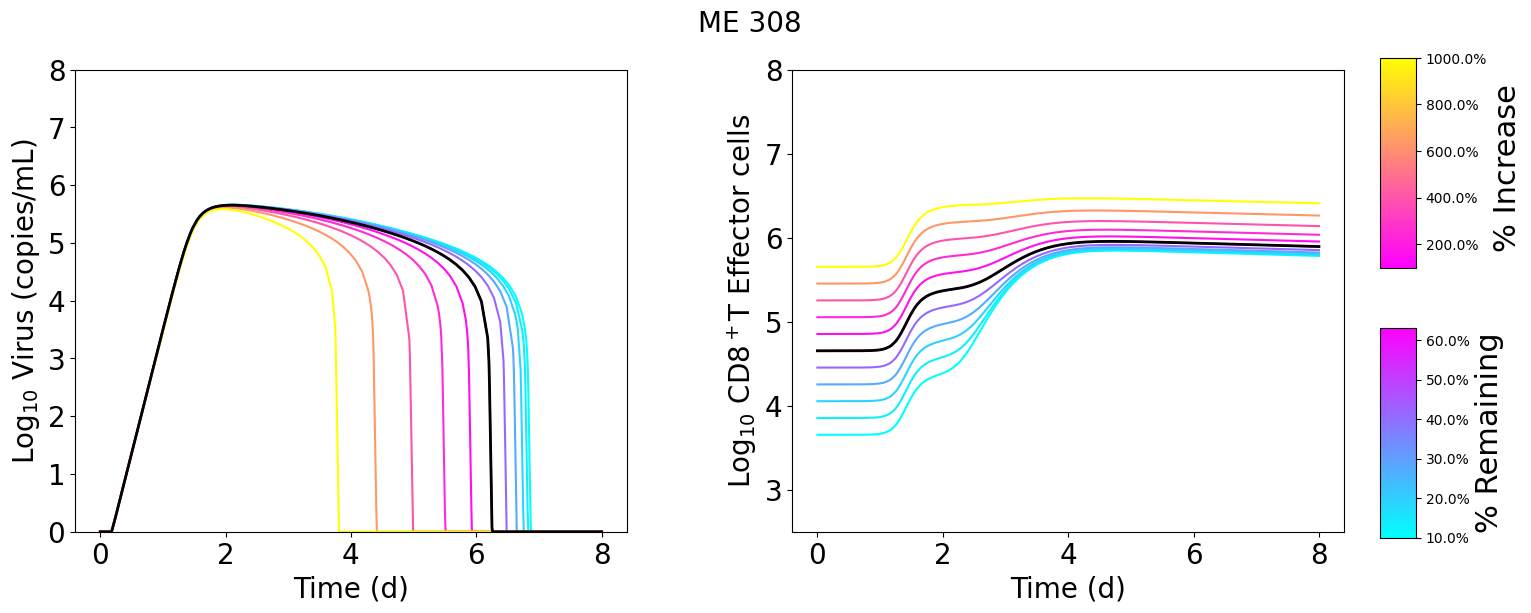

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


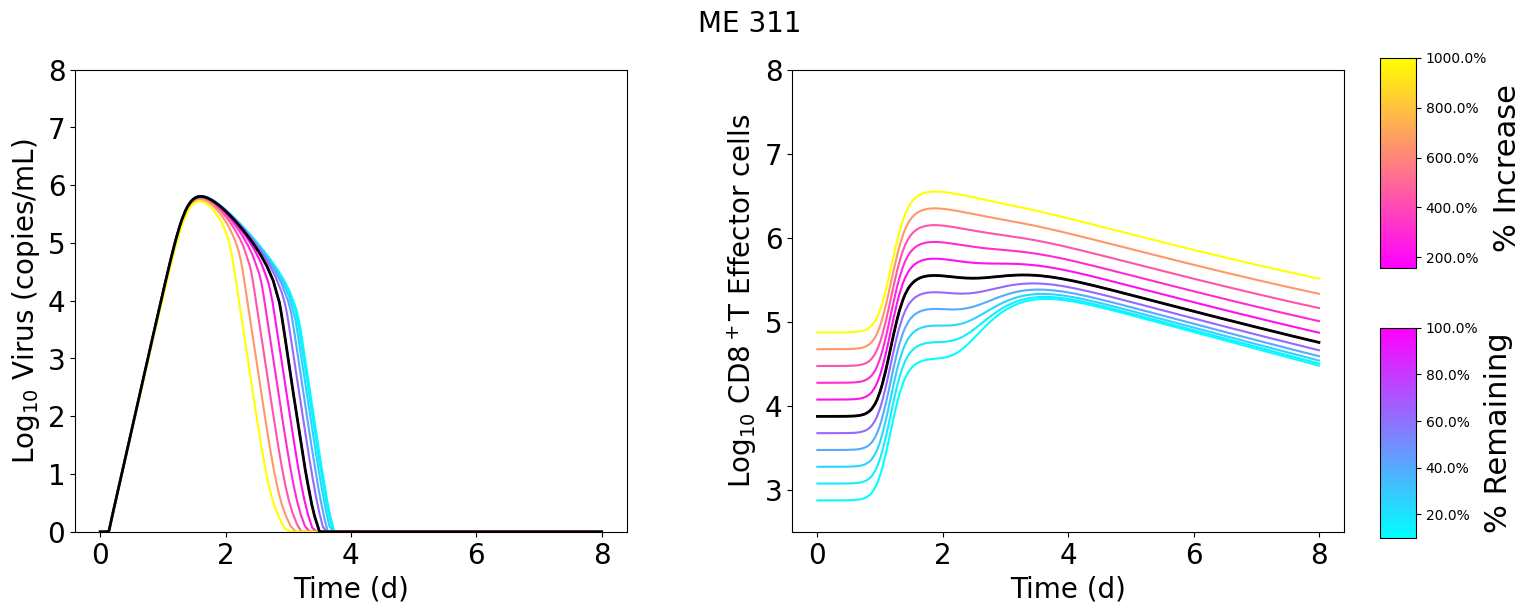

[  10.           15.84893192   25.11886432   39.81071706   63.09573445
  100.          158.48931925  251.18864315  398.10717055  630.95734448
 1000.        ]


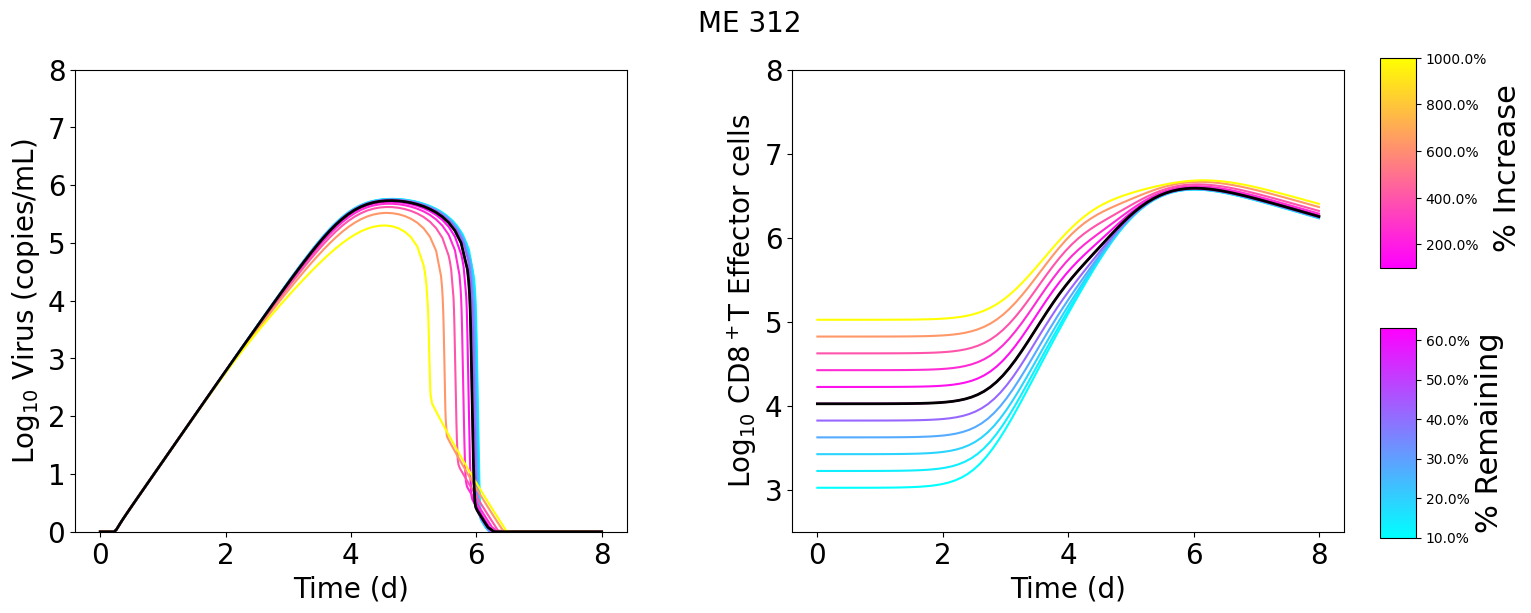

KeyError: 'Population'

In [24]:
import os
os.environ["JULIA_NUM_THREADS"] = "1"
from julia.api import Julia
julia = Julia(sysimage="sysimage_env/sysimage.so")
#julia = Julia()
from julia import Main
Main.include("models/Reinfection_model.jl")
import matplotlib.pyplot as plt
import numpy as np
import re
import matplotlib as mpl
import pandas as pd
import matplotlib.colors as mcolors

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    
    # Define the replacements
    replacements = {
        r"\bd_E\b": "dE",  # d_E -> d subscript E
        r"\bdelta\b": "δ",  # delta -> δ
        r"\bdelta_E\b": "δE",  # delta_E -> δ subscript E
        r"\bK_delta_E\b": "K(δE)",  # K_delta_E -> K subscript δ subscript E
        r"\btau\b": "τ",  # tau -> τ
        r"\bxi\b": "ξ",  # xi -> ξ
        r"\bbeta\b": "β",  # beta -> β
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",  # delta_E/K_delta_E -> δ subscript E/K subscript δ subscript E
        r"\bdelta/delta_E\b": "δ/δE",  # delta/delta_E -> δ divided by δ subscript E
        r"\beta\b": "η",  # eta -> η
        r"\bzeta\b": "ζ",  # zeta -> ζ
        r"\btau_memory\b": "τm",  # tau_memory -> τ subscript m
    }

    # Apply the replacements using regex
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)

    return fit_params_str

def sweep(t_span, y0, Zero_conditions, base_params, sweep_param, n_steps, individual_data, percent=None, log=None, id=None, data_color='black'):
    base_value = base_params[sweep_param]

    if percent is not None and log is None:
        sweep_range = (base_value * (1 - percent / 100), base_value * (1 + percent / 100))
        sweep_values = np.linspace(sweep_range[0], sweep_range[1], n_steps)
    elif log is not None and percent is None:
        sweep_range = (base_value * (10 ** -log), base_value * (10 ** log)) 
        sweep_values = 10 ** np.linspace(np.log10(sweep_range[0]), np.log10(sweep_range[1]), n_steps)

    solutions = []
    for value in sweep_values:
        params = {k: v for k, v in base_params.items() if k not in ["T0", "ME"]} 
        params[sweep_param] = value
        if sweep_param == "T0":
            y0[0] = value
        else:
            y0[0] = float(base_params["T0"])
        if sweep_param == "ME":
            y0[5] = value
        else:
            y0[5] = base_params["ME"]

        params_julia = [
        float(np.float64(params["beta"])),
        float(np.float64(params["k"])),
        float(np.float64(params["p"])),
        float(np.float64(params["c"])),
        float(np.float64(params["delta"])),
        float(np.float64(params["xi"])),
        float(np.float64(params["a"])),
        float(np.float64(params["d_E"])),
        float(np.float64(params["delta_E"])),
        float(np.float64(params["K_delta_E"])),
        float(np.float64(params["zeta"])),
        float(np.float64(params["eta"])),
        float(np.float64(params["K_I1"])),
        float(np.float64(params["tau_memory"])),
        float(np.float64(params["damp"])),
        ]
        t_values, y_values = Main.tmap_ReinfectionModel(t_span, y0, params_julia)

        # Store solutions
        solution = {
            "t": np.array(t_values, dtype=np.float64),
            "y": np.array(y_values, dtype=np.float64)
        }
        solutions.append(solution)

    # Plot results
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    cmap_decrease = plt.get_cmap("cool")
    cmap_increase = plt.get_cmap("spring")
    decreased_indices = np.where(sweep_values < base_value)[0]
    increased_indices = np.where(sweep_values >= base_value)[0]
    norm_decrease = mpl.colors.Normalize(vmin=sweep_values[decreased_indices].min(), vmax=base_value)
    norm_increase = mpl.colors.Normalize(vmin=base_value, vmax=sweep_values[increased_indices].max())
    base_font_size = 20

    for i, ax in enumerate(axs):
        for j, solution in enumerate(solutions):
            if j in decreased_indices:
                color = cmap_decrease(norm_decrease(sweep_values[j]))
            else:
                color = cmap_increase(norm_increase(sweep_values[j]))

            # Add Zero_conditions "E0" to plot 2 and "M0" to plot 3
            if i == 1:  # CD8T Effector cells
                ax.plot(solution["t"], np.log10(np.maximum(solution["y"][i + 3, :] + solution["y"][5,0], 1)), color=color)
            else:
                ax.plot(solution["t"], np.log10(np.maximum(solution["y"][i + 3, :], 1)), color=color)

        y0[0] = 4E7  
        y0[5] = base_params["ME"]
        baseline_params = {k: v for k, v in base_params.items() if k != "T0"} 

        baseline_t, baseline_y = Main.tmap_ReinfectionModel(t_span, y0, list(baseline_params.values()))
        baseline = np.log10(np.maximum(baseline_y[i + 3, :] + (Zero_conditions["ME"] if i == 1 else Zero_conditions["M0"] if i == 2 else 0), 1))
        ax.plot(baseline_t, baseline, color='black', linewidth=2, label="Cohort")

    axs[0].set_ylabel(f'Log$_{{10}}$ Virus (copies/mL)', fontsize=base_font_size)
    axs[1].set_ylabel(f'Log$_{{10}}$ CD8$^+$T Effector cells', fontsize=base_font_size)
    axs[0].set_ylim(0, 8)
    axs[1].set_ylim(2.5, 8)

    for ax in axs:
        ax.set_xlabel("Time (d)", fontsize=base_font_size)
        ax.tick_params(labelsize=base_font_size)

    title_str = f"{format_fit_params(sweep_param)} "
    if id is not None:
        title_str += str(id)
    fig.suptitle(title_str, fontsize=base_font_size)

    fig.subplots_adjust(right=0.83)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    if sweep_param == "ME":
        percent_values = (sweep_values / Zero_conditions["ME"]) * 100  # Convert to percentage
        print(percent_values)
        decreased_percent = percent_values[decreased_indices]
        increased_percent = percent_values[increased_indices]

        norm_decrease = mpl.colors.Normalize(vmin=decreased_percent.min(), vmax=decreased_percent.max())
        norm_increase = mpl.colors.Normalize(vmin=increased_percent.min(), vmax=increased_percent.max())

        cbar_ax_decrease = fig.add_axes([0.85, 0.1, 0.02, 0.35])
        cbar_ax_increase = fig.add_axes([0.85, 0.55, 0.02, 0.35])

        cbar_decrease = mpl.colorbar.ColorbarBase(cbar_ax_decrease, cmap=cmap_decrease, norm=norm_decrease, orientation='vertical')
        cbar_decrease.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
        cbar_decrease.ax.set_ylabel("% Remaining", fontsize=base_font_size + 2)

        cbar_increase = mpl.colorbar.ColorbarBase(cbar_ax_increase, cmap=cmap_increase, norm=norm_increase, orientation='vertical')
        cbar_increase.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
        cbar_increase.ax.set_ylabel("% Increase ", fontsize=base_font_size + 2)
    else:
        # Normal behavior for other sweep parameters
        norm_decrease = mpl.colors.Normalize(vmin=sweep_values[decreased_indices].min(), vmax=base_value)
        norm_increase = mpl.colors.Normalize(vmin=base_value, vmax=sweep_values[increased_indices].max())

        cbar_ax_decrease = fig.add_axes([0.85, 0.1, 0.02, 0.35])
        cbar_ax_increase = fig.add_axes([0.85, 0.55, 0.02, 0.35])

        cbar_decrease = mpl.colorbar.ColorbarBase(cbar_ax_decrease, cmap=cmap_decrease, norm=norm_decrease, orientation='vertical')
        cbar_decrease.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2E}' if x < 0.01 or x > 999 else f'{x:.2f}'))
        cbar_decrease.ax.set_ylabel("Decrease", fontsize=base_font_size + 2)

        cbar_increase = mpl.colorbar.ColorbarBase(cbar_ax_increase, cmap=cmap_increase, norm=norm_increase, orientation='vertical')
        cbar_increase.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2E}' if x < 0.01 or x > 999 else f'{x:.2f}'))
        cbar_increase.ax.set_ylabel("Increase", fontsize=base_font_size + 2)

    plt.show()

params = pd.read_excel("XiRechallenge.xlsx")
ids = params['id'].unique()

patient_color_names = [
    'gray',
    'purple',
    'magenta',
    'red',
    'goldenrod',
    'darkorange',
    'saddlebrown',
    'mediumblue',
    'dodgerblue',
    'turquoise',
    'darkgreen',
    'lawngreen',
]

patient_colors = {}
for pid, color_name in zip(ids, patient_color_names):
    rgba = mcolors.to_rgba(color_name)
    patient_colors[pid] = {
        'matplotlib': rgba,
        'plotly': mpl.colors.to_hex(rgba, keep_alpha=False)
    }

df_Rahil = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx")
df_Rahil = df_Rahil[['VOLUNTEER', 'DAY', 'V', 'TSS', 'CD8TE', 'CD8TM', 'COHORT']]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 9]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] > -0.01]
df_Rahil = df_Rahil[df_Rahil['VOLUNTEER'].isin(ids)]

t_span = (0.0, 8)  
y0 = [0, 75.0, 0.0, 0.0, 0.0, 0.0] + [0.0] * 13 
n_steps = 11 
percent = 50
log = 1
swept_params = ["ME"]

for id in ids:
    color = patient_colors[id]['matplotlib']
    row = params[params['id'] == id].iloc[0]
    base_params = {
        "T0": row['T0'],
        "beta": row['beta'],
        "k": row['k'],
        "p": row['p'],
        "c": row['c'],
        "delta": row['delta'],
        "xi": row['xi'],
        "a": row['a'],
        "d_E": row['d_E'],
        "delta_E": row['delta_E'],
        "K_delta_E": row['K_delta_E'],
        "zeta": row['zeta'],
        "eta": row['eta'],
        "K_I1": row['K_I1'],
        "tau_memory": row['tau_memory'],
        "damp": row['damp'],
        "ME": row['ME']        
    }
    Zero_conditions = {
        "ME": row['ME'],
        "M0": row['M0'],
    }
    individual_data = df_Rahil[df_Rahil['VOLUNTEER'].isin([id])]
    for param in swept_params:
        sweep_param = param
        #sweep(t_span, y0, Zero_conditions, base_params, sweep_param, n_steps, individual_data, percent=percent, id=id, data_color=color)
        sweep(t_span, y0, Zero_conditions, base_params, sweep_param, n_steps, individual_data, log=log, id=id, data_color=color)